# **Autoencoders**

Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction. Autoencoders: <br>


* Act as powerful feature detectors, and they can be used for unsupervised pre-training of deep neural networks. 
* Can randomly generating new data that looks very similar to the training data, for example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces.
* Learn create a modified copy of inputs to outputs.

Which of the following number sequences do you find the easiest to memorize? <br>

40, 27, 25, 36, 81, 57, 10, 73, 19, 68 <br>
<br>
0, 25, 76, 38, 19, 58, 29, 88, 44, 22, 11, 34, 17, 52, 26, 13, 40, 20 <br>

The longer one is just: <br>
If $n$ is even, divide it by $2$ to give $n^\prime = n/2$. <br>
If $n$ is odd, multiply it by $3$ and add $1$ to give $n^\prime = 3n + 1.$

Chess players can memorize real (not random position) in 5 sec. Similarly, autoencoder looks at the inputs, converts them to an efficient internal representation, and then spits out something that (hopefully) looks very close to the inputs.


An autoencoder is always composed of two parts:
* Encoder (or recognition network) that converts the inputs to an internal representation
* Decoder (or generative network) that converts the internal representation to the outputs

An autoencoder typically has the same architecture as DNN, except that the number of neurons in the output layer must be equal to the number of inputs. 



![Neuron inner working](images/Chapter15/image_15_1.png)

Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be undercomplete. <br>


An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).

# Performing PCA with an Undercomplete Linear Encoder

An autoencoder with linear activations and the Mean Squared Error (MSE) cost function ends up performing Principal Component Analysis.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [125]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
from timeit import default_timer as timer

A couple utility functions to plot grayscale 28x28 image:

In [126]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [127]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [128]:
# Create random data
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Normalize the data:

In [129]:
# Scale data and divide into training and testing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Now let's build the Autoencoder...

Note: instead of using the `fully_connected()` function from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()` function from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).
* the `weights` parameter was renamed to `kernel` and the weights variable is now named `"kernel"` rather than `"weights"`,
* the bias variable is now named `"bias"` rather than `"biases"`,
* the default activation is `None` instead of `tf.nn.relu`

In [130]:
import tensorflow as tf

reset_graph()
# Create [3,2,3] network
n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)
# We want to minimize reconstruction loss (MSE)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

Key features:
* The number of outputs is equal to the number of inputs
* To perform simple PCA, we set activation_fn=None (i.e., all neurons are linear) and the cost function is the MSE.

Next we load the dataset, train the model on the training set, and use it to encode the test set

In [131]:
n_iterations = 1000
# Coding information is in the hidden 2-neuron layer
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
# Train using training
        training_op.run(feed_dict={X: X_train})
# Evaluate using testing
    codings_val = codings.eval(feed_dict={X: X_test})

Saving figure linear_autoencoder_pca_plot


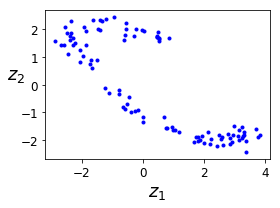

In [132]:
# Plot linear encoding
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Autoencoders can have multiple hidden layers: stacked autoencoders or deep autoencoders. Adding more layers helps the autoencoder learn more complex codings. Similar to DNN more complex autoencoders are prone to overfitting.


The architecture of a stacked autoencoder is typically symmetrical with regards to the central hidden layer (the coding layer). Below is an example of [784,300,150,300,784] MNIST decoder.

![Neuron inner working](images/Chapter15/image_15_2.png)

Let's use MNIST:

In [133]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`).

In [134]:
reset_graph()
# Tool to creat higher order functions
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
# L2 regulation
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
# He initialization
he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)
# Build network
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
# Loss function
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# Add L2 function to the loss function
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

Now let's train it! Note that we don't feed target values (`y_batch` is not used). This is unsupervised training.

In [135]:
start = timer()
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
# Loop over epochs
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
# Loop over batches
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown
end = timer()
print("Training all layers took ",end - start," seconds")
All_lay = end - start

0 Train MSE: 0.020302307
1 Train MSE: 0.011643166
2 Train MSE: 0.010225781
3 Train MSE: 0.009899946
4 Train MSE: 0.010377405
Training all layers took  22.003194852046363  seconds


This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [136]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_test}) 
        print("Reconstruction Loss using testing data is",loss_train)
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Reconstruction Loss using testing data is 0.012036335
Saving figure reconstruction_plot


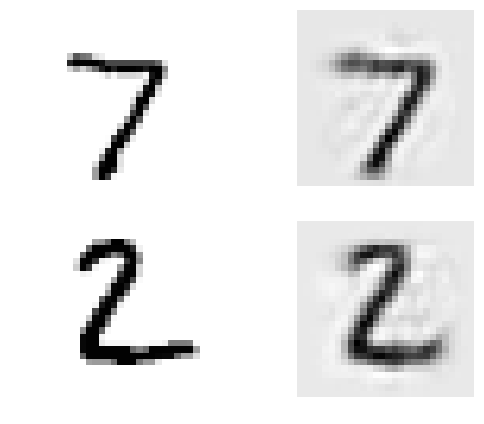

In [137]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## Tying weights

When an autoencoder is symmetrical, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of over-fitting.


For an encoder or $N$ layers with $W_L$ weights of each layer, we set $W_{N-L+1}=W_{L}^T$. For $N = 5$ and $L = 1$:  $W_5 = W_1$, etc. Weights in lower level are for coding and the transposed weights in the upper layers are for encoding. 


It is common to tie the weights of the encoder and the decoder (`weights_decoder = tf.transpose(weights_encoder)`). Unfortunately this makes it impossible (or very tricky) to use the `tf.layers.dense()` function, so we need to build the Autoencoder manually:

In [138]:
#Setup constancts
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

Network has a structure [784,300,150,300,784]

In [139]:
# ELU activation function
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
# He initialization
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
# Initial weights 
# First layers with 784->300
weights1_init = initializer([n_inputs, n_hidden1])
# Second layer with 300->150
weights2_init = initializer([n_hidden1, n_hidden2])
# Create TF variables for two layers
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
# Transpose weights for decoding
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights
# Get biases. we have 5 layers and 4 sets of weights connecting them
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")
# Set-up first 3 layers
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4
# Setup reconstrication and regularization loss functions
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [140]:
saver = tf.train.Saver()

In [141]:
n_epochs = 5
batch_size = 150


start = timer()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")
end = timer()
print("Tying weights we got",end - start, "seconds")
tie_w = end - start

0 Train MSE: 0.015066842
1 Train MSE: 0.016488561
2 Train MSE: 0.017375803
3 Train MSE: 0.016878227
4 Train MSE: 0.015587644
Tying weights we got 27.124152516016693 seconds


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt
Reconstruction Loss using testing data is 0.020814966


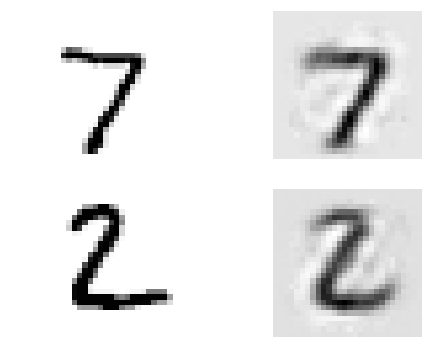

In [142]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

Reconstruction loss is higher than using non-symmetric weights.

## Training one Autoencoder at a time in multiple graphs

Rather than training the whole stacked autoencoder in one go, it is often much faster to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder. This is especially useful for very deep autoencoders with a lot of data.

![Neuron inner working](images/Chapter15/image_15_4.png)

* During the first phase of training, the first autoencoder learns to reconstruct the inputs. 
* During the second phase, the second autoencoder learns to reconstruct the output of the first autoencoder’s hidden layer. 
* Finally, you just build a big sandwich using all these autoencoders. This gives you the final stacked autoencoder. You could easily train more autoencoders this way, building a very deep stacked autoencoder.

We will use TensorFlow. After training an autoencoder, you just run the training set through it and capture the output of the hidden layer. 

This output then serves as the training set for the next autoencoder. 

Once all autoencoders have been trained this way, you simply copy the weights and biases from each autoencoder and use them to build the stacked autoencoder. Implementing this approach is quite

* We will train different TensorFlow graph for each phase.
* After training an autoencoder, you just run the training set through it and capture the output of the hidden layer.This output then serves as the training set for the next autoencoder. 
* Once all autoencoders have been trained this way, you simply copy the weights and biases from each autoencoder and use them to build the stacked autoencoder. 

There are many ways to train one Autoencoder at a time. The first approach is to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [143]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        # Create function of intial intialization and regularization
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
# Hidden neuron
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
# Create reconstruction loss function
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
#Regularization loss
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#Add two loss functions
        loss = tf.add_n([reconstruction_loss] + reg_losses)
#Specify optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                #Shuffle Data the draw a new batch
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                #Estimate training in the batch
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        #Save values from the hidden layers
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [144]:
start = timer()
# We export weights and outputs from one layer of 300 neurons
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
# We reuse output from layer 1 to layer 2. "_,"" ignores first parameters. Estimated W3, W2.
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)
end = timer()
print("Training one encoder at a time takes",end - start, "seconds")
OneEnc = end - start

0 Train MSE: 0.018517738
1 Train MSE: 0.0186826
2 Train MSE: 0.018467626
3 Train MSE: 0.019231623
0 Train MSE: 0.0042361086
1 Train MSE: 0.0048326803
2 Train MSE: 0.004668748
3 Train MSE: 0.0044039097
Training one encoder at a time takes 30.305388787535776 seconds


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [145]:
# We estiamted all weights, not we just contruct network with estimated weights.
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

In [146]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

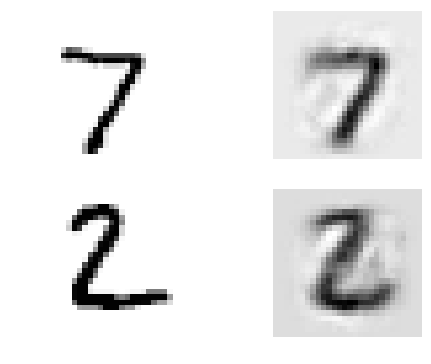

In [147]:
show_reconstructed_digits(X, outputs)

## Training one Autoencoder at a time in a single graph

Another approach is to use a single graph containing the whole stacked autoencoder, plus some extra operations to perform each training phase:

![Neuron inner working](images/Chapter15/image_15_5.png)

* The central column in the graph is the full stacked autoencoder used after training.
* The left column is the first stage that creates an output layer that bypasses hidden layers 2 and 3. This output layer shares the same weights and biases as the stacked autoencoder’s output layer. This phase will train the weights and biases for the hidden layer 1 and the output layer.
* The right column is the second phase that creates training operation aiming at making the output of hidden layer 3 close to the output of hidden layer 1. We must freeze hidden layer 1 while running phase 2. This phase will train the weights and biases for hidden layers 2 and 3 (i.e., the second autoencoder).


In [148]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])
# Weights are flexible
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [149]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    #We predict layers hidden3 using hidden1
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    #Add regularizations (1->2) and (2->3)
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    # The variables we estimate, leaving out weights1 and biases1
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

**Phase 1** We  create an output layer that skips hidden layers 2 and 3 and build the training operations to minimize the distance between the outputs and the inputs (plus some regularization).<br>

**Phase 2** We add the operations needed to minimize the distance between the output of hidden layer 3 and hidden layer 1 <br>

Most importantly, we provide the list of trainable variables to the minimize() method, making sure to leave out weights1 and biases1; this effectively freezes hidden layer 1 during phase 2.

In [150]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

We will run the phase 1 training op for a number of epochs, then the phase 2 training op for some more epochs.

In [151]:
start = timer()
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)
end = timer()
print("Training one encoder in a single graph takes",end - start, "seconds")
OneEnc_singGR = end - start

Training phase #1
0 Train MSE: 0.0074068382
1 Train MSE: 0.0078287525
2 Train MSE: 0.007728059
3 Train MSE: 0.0074089756
Training phase #2
0 Train MSE: 0.3257823
1 Train MSE: 0.00573954
2 Train MSE: 0.0029418417
3 Train MSE: 0.0024437662
Test MSE: 0.009793411
Training one encoder in a single graph takes 29.159481976459574 seconds


Since hidden layer 1 is frozen during phase 2, its output will always be the same for any given training instance. To avoid having to recompute the output of hidden layer 1 at every single epoch, you can compute it for the whole training set at the end of phase 1, then directly feed the cached output of hidden layer 1 during phase 2. This can give you a nice performance boost.

## Cache the frozen layer outputs

## Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


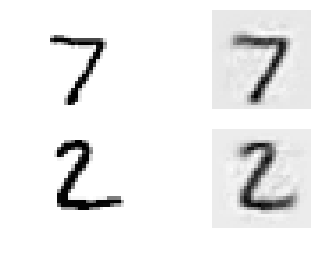

In [152]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## Visualizing the extracted features

Once your autoencoder has learned some features, you may want to take a look at them.
* the simplest technique is to consider each neuron in every hidden layer, and find the training instances that activate it the most. 
* This is especially useful for the top hidden layers since they often capture relatively large features that you can easily spot in a group of training instances that contain them.

* For example, if a neuron strongly activates when it sees a cat in a picture, it will be pretty obvious that the pictures that activate it the most all contain cats. However, for lower layers, this technique does not work so well, as the features are smaller and more abstract, so it’s often hard to understand exactly what the neuron is getting all excited about.

Using another technique we can create an image where a pixel’s intensity corresponds to the weight of the connection to the given neuron. For example, the following code plots the features learned by five neurons in the first hidden layer:

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt
Saving figure extracted_features_plot


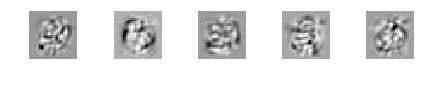

In [153]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    #Weights
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot") # not shown
plt.show()                          # not shown

The first four features seem to correspond to small patches, while the fifth feature seems to look for vertical strokes.

Another technique is to feed the autoencoder a random input image, measure the activation of the neuron you are interested in, and then perform backpropagation to tweak the image in such a way that the neuron will activate even more. If you iterate several times (performing gradient ascent), the image will gradually turn into the most exciting image (for the neuron). This is a useful technique to visualize the kinds of inputs that a neuron is looking for.

# Unsupervised pretraining

if you are tackling a complex supervised task but you do not have a lot of labeled training data, one solution is to find a neural network that performs a similar task, and then reuse its lower layers.

This makes it possible to train a high-performance model using only little training data because your neural network won’t have to learn all the low-level features; it will just reuse the feature detectors learned by the existing net.

Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task, and train it using the labeled data. 

The stacked autoencoder itself is typically trained one autoencoder at a time. When training the classifier, if you really don’t have much labeled training data, you may want to freeze the pretrained layers (at least the lower ones).

![Neuron inner working](images/Chapter15/Figure_15_8.png)

This situation is common, because building a large unlabeled dataset is often cheap (e.g., a simple script can download millions of images off the internet), but labeling them can only be done reliably by humans (e.g., classifying images as cute or not). 

Labeling instances is time-consuming and costly, so it is quite common to have only a few thousand labeled instances.

Let's train data on outputs and recycle layers 4 with 300 neurons from the run on unlabeled data

In [154]:
start = timer()
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]
with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)
end = timer()
print("Training one encoder caching frozen layers",end - start, "seconds")
OneEnc_singGR = end - start

Training phase #1
0 Train MSE: 0.007538227
1 Train MSE: 0.007754632
2 Train MSE: 0.007343643
3 Train MSE: 0.007837738
Training phase #2
0 Train MSE: 0.16884093
1 Train MSE: 0.0044883126
2 Train MSE: 0.0024808452
3 Train MSE: 0.0020300867
Test MSE: 0.009770555
Training one encoder caching frozen layers 29.704416298218348 seconds


In [163]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [165]:
start = timer()
n_epochs = 4
batch_size = 150
# Use 1000 obs broken into batches
n_labeled_instances = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

end = timer()
print("Pretraining takes",end - start, "seconds")
pretr = end - start

0 Train accuracy: 0.4 Test accuracy: 0.4501
1 Train accuracy: 0.7733333 Test accuracy: 0.709
2 Train accuracy: 0.8 Test accuracy: 0.7556
3 Train accuracy: 0.74 Test accuracy: 0.7805
Pretraining takes 0.7785522873655282 seconds


Now reusing the first two layers of the autoencoder we pretrained:

In [164]:
start = timer()
n_epochs = 4
batch_size = 150
n_labeled_instances = 1000

training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)
end = timer()        
print("Reusing takes",end - start, "seconds")
pretr = end - start

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.42	Test accuracy: 0.3462
1 Train accuracy: 0.64	Test accuracy: 0.6283
2 Train accuracy: 0.7733333	Test accuracy: 0.7368
3 Train accuracy: 0.78	Test accuracy: 0.7783
Reusing takes 0.9450459745112312 seconds


# Stacked denoising Autoencoder

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. 

This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout.

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

![Neuron inner working](images/Chapter15/image_15_9.png)

Using Gaussian noise:

In [176]:
# Networks [784,300,150,300,784]
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

* Since the shape of X is only partially defined during the construction phase, we cannot know in advance the shape of the noise that we must add to X. 

* We cannot call X.get_shape() because this would just return the partially defined shape of X ([None, n_inputs]), and random_normal() expects a fully defined shape so it would raise an exception. 

* Instead, we call tf.shape(X), which creates an operation that will return the shape of X at runtime, which will be fully defined at that point.

In [177]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
# Add noise to X
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [178]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [171]:
n_epochs = 10
batch_size = 150
start = timer()  
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("Test accuracy:", accuracy_val)
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")
end = timer()        
print("Noising takes",end - start, "seconds")
noise = end - start

0%

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,784]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 301, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1198, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 125, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-167-b1fcfb908534>", line 3, in <module>
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5928, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,784]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


Using dropout:

In [179]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [180]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [181]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [182]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.038432386
1 Train MSE: 0.034614805
2 Train MSE: 0.032883618
3 Train MSE: 0.030497398
4 Train MSE: 0.028540833
5 Train MSE: 0.026734976
6 Train MSE: 0.027766291
7 Train MSE: 0.026757905
8 Train MSE: 0.0269874
9 Train MSE: 0.025499795


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


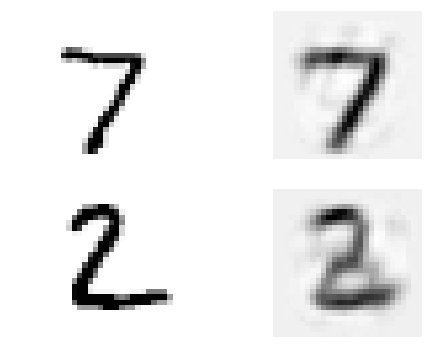

In [60]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# Sparse Autoencoder

Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. 

For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. 

As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).

In order to favor sparse models, we must first measure the actual sparsity of the coding layer at each training iteration. 

We do so by computing the average activation of each neuron in the coding layer, over the whole training batch.

The batch size must not be too small, or else the mean will not be accurate.

Once we have the mean activation per neuron, we want to penalize the neurons that are too active by adding a sparsity loss to the cost function.

For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1, it must be penalized to activate less. One approach could be simply adding the squared error (0.3 – 0.1) to the cost function, but in practice a better approach is to use the Kullback–Leibler divergence, which has much stronger gradients than the Mean Squared Error.

![Neuron inner working](images/Chapter15/image_15_10.png)

Given two discrete probability distributions $P$ and $Q$, the $KL$ divergence between these distributions, noted $D_{KL}(P || Q)$, can be computed using:
$$D_{KL}(P || Q) = \sum_i P(i) = \log \frac{P(i)}{Q(i)}$$
The divergence between the target probability $p$ that a neuron in the coding layer will activate, and the actual probability $q$ (i.e., the mean activation over the training batch):
$$D_{KL}(P || Q) = \sum_i P(i) = p  \log \frac{p}{q} + (1-p)\log \frac{1-p}{1-q}$$
$KL$ divergence between the target sparsity p and the actual sparsity q <br>

* Once we have computed the sparsity loss for each neuron in the coding layer, we just sum up these losses, and add the result to the cost function. 

* In order to control the relative importance of the sparsity loss and the reconstruction loss, we can multiply the sparsity loss by a sparsity weight hyperparameter. 

* If this weight is too high, the model will stick closely to the target sparsity, but it may not reconstruct the inputs properly, making the model useless.

* Conversely, if it is too low, the model will mostly ignore the sparsity objective and it will not learn any interesting features.

Saving figure sparsity_loss_plot


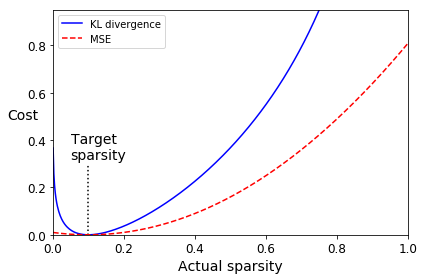

In [183]:
# Target sparcity
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [185]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [186]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2 # How much do we care about sparcify

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [187]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [188]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13261387 	Sparsity loss: 0.8514364 	Total loss: 0.30290115
1 Train MSE: 0.058964375 	Sparsity loss: 0.009240762 	Total loss: 0.06081253
2 Train MSE: 0.05352246 	Sparsity loss: 0.10844844 	Total loss: 0.07521215
3 Train MSE: 0.04778698 	Sparsity loss: 0.017166104 	Total loss: 0.0512202
4 Train MSE: 0.04419022 	Sparsity loss: 0.07803779 	Total loss: 0.05979778
5 Train MSE: 0.041086096 	Sparsity loss: 0.010685035 	Total loss: 0.0432231
6 Train MSE: 0.03871162 	Sparsity loss: 0.021964733 	Total loss: 0.043104567
7 Train MSE: 0.035334036 	Sparsity loss: 0.07734299 	Total loss: 0.050802633
8 Train MSE: 0.03435647 	Sparsity loss: 0.062260263 	Total loss: 0.046808526
9 Train MSE: 0.030322136 	Sparsity loss: 0.01769763 	Total loss: 0.033861663
10 Train MSE: 0.027049495 	Sparsity loss: 0.01730853 	Total loss: 0.0305112
11 Train MSE: 0.026348555 	Sparsity loss: 0.39745924 	Total loss: 0.1058404
12 Train MSE: 0.023475178 	Sparsity loss: 0.05130941 	Total loss: 0.03373706
13 Train MS

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


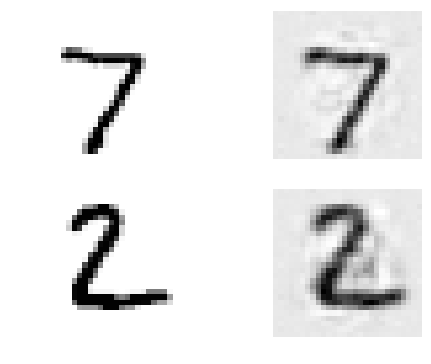

In [189]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

Note that the coding layer must output values from 0 to 1, which is why we use the sigmoid activation function:

In [193]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

To speed up training, you can normalize the inputs between 0 and 1, and use the cross entropy instead of the MSE for the cost function:

In [194]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

# Variational Autoencoder

* probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).
* Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.

They are easy to train

See image.
An encoder followed by a decoder (in this example, they both have two hidden layers), but there is a twist: instead of directly producing a coding for a given input, the encoder produces a mean coding $\mu$ and a standard deviation $\sigma$. The actual coding is then sampled randomly from a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$. After that the decoder just decodes the sampled coding normally. 

The right part of the diagram shows a training instance going through this autoencoder. First, the encoder produces $\mu$ and $\sigma$, then a coding is sampled randomly (notice that it is not exactly located at $\mu$), and finally this coding is decoded, and the final output resembles the training instance.

![Neuron inner working](images/Chapter15/image_15_11.png)

Although the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though they were sampled from a simple Gaussian distribution: during training, the cost function pushes the codings to gradually migrate within the coding space (also called the latent space) to occupy a roughly (hyper)spherical region that looks like a cloud of Gaussian points. One great consequence is that after training a variational autoencoder, you can very easily generate a new instance: just sample a random coding from the Gaussian distribution.

In [195]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
# [500,500,20,500,500]
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
# Build layer 3
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
# Create noise random normal (0,1) with the shape of the second layr
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
# New layers 3:   E(x) + E(X) * noise
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

So let’s look at the cost function. It is composed of two parts. 

1. usual reconstruction loss that pushes the autoencoder to reproduce its inputs. 
2. latent loss that pushes the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution, for which we use the $KL$ divergence between the target distribution (the Gaussian distribution) and the actual distribution of the codings. 

The math is a bit more complex than earlier, in particular because of the Gaussian noise, which limits the amount of information that can be transmitted to the coding layer (thus pushing the autoencoder to learn useful features). Luckily, the equations simplify to the following code for the latent loss:

In [196]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [197]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [198]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 31827.45 	Reconstruction loss: 23177.785 	Latent loss: 8649.664
1 Train total loss: 25788.158 	Reconstruction loss: 21693.416 	Latent loss: 4094.7422
2 Train total loss: 30398.889 	Reconstruction loss: 23400.795 	Latent loss: 6998.094
3 Train total loss: 23347.68 	Reconstruction loss: 20350.848 	Latent loss: 2996.8325
4 Train total loss: 26416.398 	Reconstruction loss: 21959.316 	Latent loss: 4457.083
5 Train total loss: 25807.885 	Reconstruction loss: 20476.496 	Latent loss: 5331.3887
6 Train total loss: 22197.78 	Reconstruction loss: 18153.455 	Latent loss: 4044.3247
7 Train total loss: 25950.355 	Reconstruction loss: 20121.96 	Latent loss: 5828.394
8 Train total loss: 18540.803 	Reconstruction loss: 15401.947 	Latent loss: 3138.8557
9 Train total loss: 18733.467 	Reconstruction loss: 15620.656 	Latent loss: 3112.8113
10 Train total loss: 16522.545 	Reconstruction loss: 13404.286 	Latent loss: 3118.2583
11 Train total loss: 16543.26 	Reconstruction loss: 13404.922

In [199]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean =  my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
# sigma = exp(gamma/2)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Generate digits

Let's train the model and generate a few random digits:

Now let’s use this variational autoencoder to generate images that look like handwritten digits. All we need to do is train the model, then sample random codings from a Gaussian distribution and decode them.

In [200]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    # Create rnadom numbers to convernt
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    # export random number
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 17930.684 	Reconstruction loss: 14299.973 	Latent loss: 3630.7104
1 Train total loss: 17223.959 	Reconstruction loss: 13442.303 	Latent loss: 3781.6562
2 Train total loss: 16563.273 	Reconstruction loss: 12765.765 	Latent loss: 3797.5098
3 Train total loss: 17105.156 	Reconstruction loss: 13239.089 	Latent loss: 3866.0674
4 Train total loss: 15680.941 	Reconstruction loss: 11960.42 	Latent loss: 3720.5212
5 Train total loss: 16084.097 	Reconstruction loss: 12294.932 	Latent loss: 3789.1648
6 Train total loss: 15731.768 	Reconstruction loss: 11913.061 	Latent loss: 3818.707
7 Train total loss: 15707.573 	Reconstruction loss: 12028.109 	Latent loss: 3679.464
8 Train total loss: 15654.68 	Reconstruction loss: 11886.244 	Latent loss: 3768.435
9 Train total loss: 15507.9375 	Reconstruction loss: 11743.331 	Latent loss: 3764.606
10 Train total loss: 15883.347 	Reconstruction loss: 12054.471 	Latent loss: 3828.8757
11 Train total loss: 15900.213 	Reconstruction loss: 12038

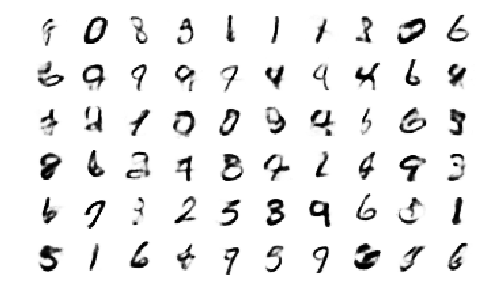

In [201]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

Saving figure generated_digits_plot


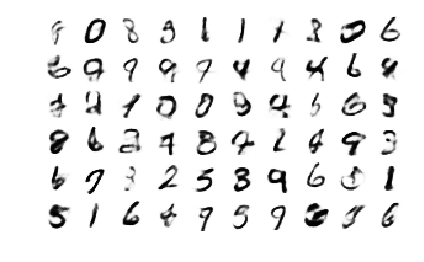

In [202]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

Note that the latent loss is computed differently in this second variant:

In [203]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

## Encode & Decode

Encode:

In [204]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Decode:

In [205]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Let's plot the reconstructions:

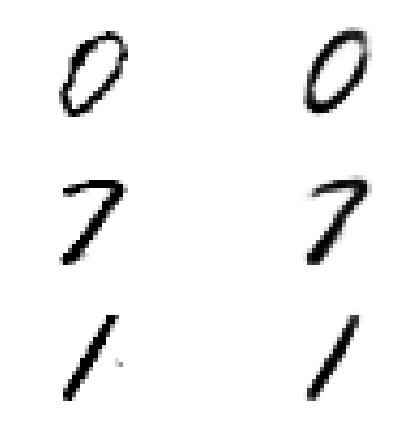

In [206]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


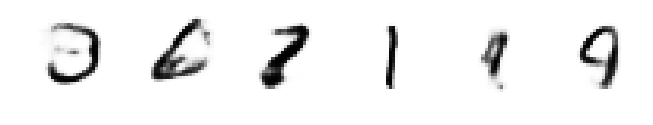

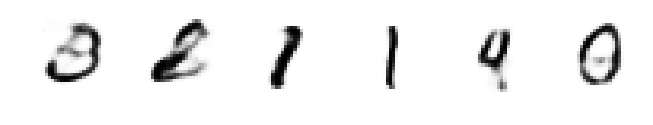

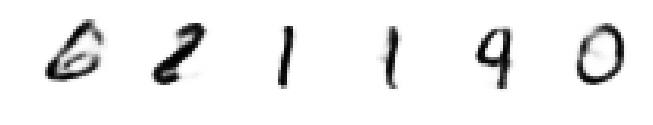

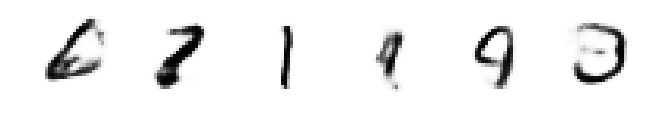

In [207]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# Exercise solutions

Coming soon...